# Email Spam Classification - Exploratory Data Analysis

**Dataset:** Email Spam Classification Dataset (Kaggle 2023)  
**Fonte:** https://www.kaggle.com/datasets/purusinghvi/email-spam-classification-dataset  
**Total:** 83,448 emails  
**Objetivo:** Analisar padrões de spam vs ham para construir classificador ML
## Por que fazer Análise Exploratória de Dados (EDA)?

A EDA é fundamental antes de treinar qualquer modelo de Machine Learning porque:

1. **Entender os dados**: Conhecer a estrutura, tipos e qualidade dos dados
2. **Identificar problemas**: Valores nulos, duplicatas, outliers
3. **Descobrir padrões**: Diferenças entre spam e ham
4. **Guiar feature engineering**: Decidir quais transformações aplicar
5. **Escolher modelos adequados**: Entender a complexidade do problema

Sem EDA, corremos o risco de treinar modelos com dados ruins ou mal preparados.

In [1]:
# Standard library
import warnings
from pathlib import Path

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing
import re
from collections import Counter
from wordcloud import WordCloud

# NLP
import nltk
from nltk.corpus import stopwords

# Configurações
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)

print("Bibliotecas importadas com sucesso!")
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Scikit-learn disponível")

Bibliotecas importadas com sucesso!
Pandas version: 2.2.3
Numpy version: 2.1.3
Scikit-learn disponível


In [2]:
# Caminho do dataset
data_path = Path('data/emails.csv')

# Carregar dados
print("Carregando dataset...")
df = pd.read_csv(data_path)

print(f"Dataset carregado com sucesso!")
print(f"\nShape: {df.shape}")
print(f"Total de emails: {len(df):,}")

# Visualizar primeiras linhas
df.head(10)

Carregando dataset...
Dataset carregado com sucesso!

Shape: (83448, 2)
Total de emails: 83,448


,label,message
0,spam,ounce feather bowl hummingbird opec moment alabaster valkyrie dyad bread flack desperate iambic ...
1,spam,wulvob get your medircations online qnb ikud viagra escapenumber escapenumber levitra escapenumb...
2,ham,computer connection from cnn com wednesday escapenumber may escapenumber escapenumber escapenum...
3,spam,university degree obtain a prosperous future money earning power and the prestige that comes wit...
4,ham,thanks for all your answers guys i know i should have checked the rsync manual but i would rathe...
5,ham,larry king live at escapenumber escapenumber p m et on friday june escapenumber escapenumber cnn...
6,ham,michael pobega wrote i'm not sure if it's the mpl or mozilla that didn't allow the distribution ...
7,ham,hi i have this error tr sample escapenumber escapenumber escapenumber train rbind irisescapenumb...
8,spam,works gateway world art explore tattooing full flow walking canvases menu choose folder open dia...
9,spam,upon this account he is not only very cautious himself but but some escapenumber men would be wi...


In [3]:
print(f"Shape: {df.shape}")
print(f"Colunas: {df.columns.tolist()}")
print(f"Tipos de dados:")
print(df.dtypes)
df.info()

Shape: (83448, 2)
Colunas: ['label', 'message']
Tipos de dados:
label      object
message    object
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83448 entries, 0 to 83447
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    83448 non-null  object
 1   message  83448 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB



Valores nulos (missing values) podem:

- **Causar erros** durante o treinamento do modelo
- **Reduzir a qualidade** das predições
- **Enviesar** os resultados

Precisamos saber:
- Quais colunas têm valores nulos?
- Quantos são?
- Como tratá-los? (remover linhas, preencher com média, etc)

Em NLP (processamento de texto), mensagens vazias ou nulas devem ser removidas.

In [4]:
# Verificar valores nulos
missing = df.isnull().sum()
missing_pct = (df.isnull().sum() / len(df)) * 100

missing_df = pd.DataFrame({
    'Valores Nulos': missing,
    'Percentual (%)': missing_pct.round(2)
})
print(missing_df)

if missing.sum() == 0:
    print("\nNenhum valor nulo encontrado! Dataset limpo!")
else:
    print(f"\nTotal de valores nulos: {missing.sum()}")
    print("\nSerá necessário tratar valores nulos antes do treinamento")

         Valores Nulos  Percentual (%)
label                0             0.0
message              0             0.0

Nenhum valor nulo encontrado! Dataset limpo!


In [5]:
# Análise da distribuição spam vs ham
class_counts = df['label'].value_counts()
print("Contagem absoluta:")
print(class_counts)

class_pct = df['label'].value_counts(normalize=True) * 100
print("Percentual:")
print(class_pct.round(2))

# Estatísticas
total = len(df)
spam_count = (df['label'] == 'spam').sum()
ham_count = (df['label'] == 'ham').sum()
ratio = spam_count / ham_count

print(f"Total de emails: {total:,}")
print(f"Spam: {spam_count:,} ({spam_count/total*100:.2f}%)")
print(f"Ham: {ham_count:,} ({ham_count/total*100:.2f}%)")
print(f"Ratio Spam/Ham: {ratio:.2f}")

if 0.8 <= ratio <= 1.2:
    print("Dataset bem balanceado!")
elif 0.5 <= ratio <= 2.0:
    print("Dataset razoavelmente balanceado")
else:
    print("Dataset desbalanceado - considerar técnicas de balanceamento")

Contagem absoluta:
label
spam    43910
ham     39538
Name: count, dtype: int64
Percentual:
label
spam    52.62
ham     47.38
Name: proportion, dtype: float64
Total de emails: 83,448
Spam: 43,910 (52.62%)
Ham: 39,538 (47.38%)
Ratio Spam/Ham: 1.11
Dataset bem balanceado!


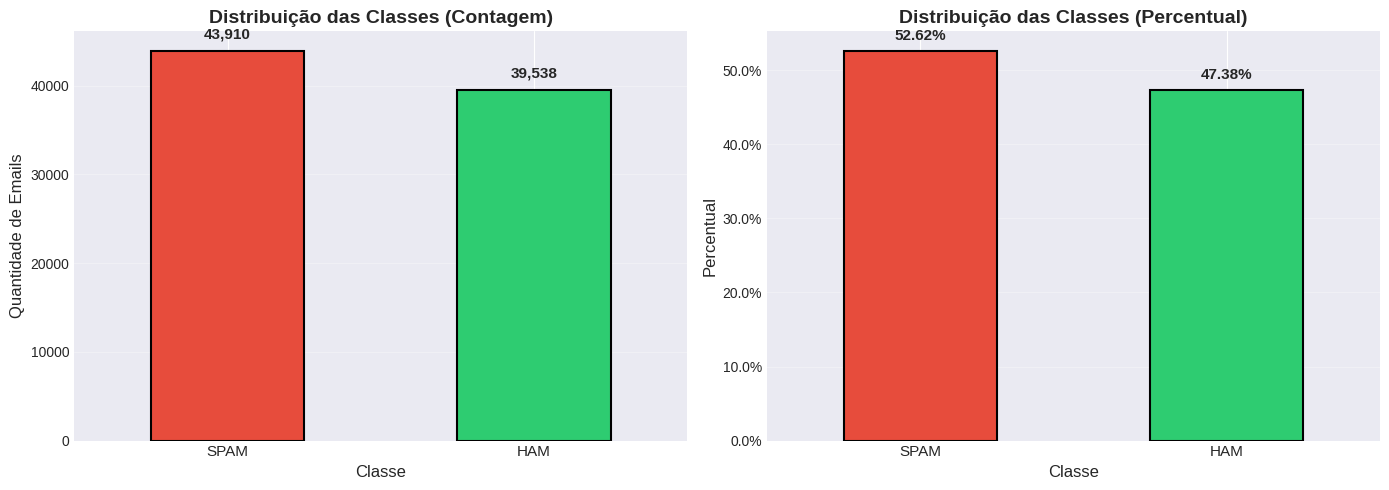

In [6]:
# Gráfico de barras da distribuição
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Contagem absoluta
colors = ['#e74c3c', '#2ecc71']  # vermelho=spam, verde=ham
df['label'].value_counts().plot(
    kind='bar', 
    ax=axes[0], 
    color=colors,
    edgecolor='black',
    linewidth=1.5
)
axes[0].set_title('Distribuição das Classes (Contagem)', 
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Classe', fontsize=12)
axes[0].set_ylabel('Quantidade de Emails', fontsize=12)
axes[0].set_xticklabels(['SPAM', 'HAM'], rotation=0, fontsize=11)
axes[0].grid(axis='y', alpha=0.3)

# Adicionar valores nas barras
for i, v in enumerate(df['label'].value_counts()):
    axes[0].text(i, v + 1000, f'{v:,}', ha='center', va='bottom', 
                 fontweight='bold', fontsize=11)

# Plot 2: Percentual
df['label'].value_counts(normalize=True).plot(
    kind='bar',
    ax=axes[1],
    color=colors,
    edgecolor='black',
    linewidth=1.5
)
axes[1].set_title('Distribuição das Classes (Percentual)', 
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Classe', fontsize=12)
axes[1].set_ylabel('Percentual', fontsize=12)
axes[1].set_xticklabels(['SPAM', 'HAM'], rotation=0, fontsize=11)
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.1f}%'))
axes[1].grid(axis='y', alpha=0.3)

# Adicionar valores nas barras
for i, v in enumerate(df['label'].value_counts(normalize=True)):
    axes[1].text(i, v + 0.01, f'{v*100:.2f}%', ha='center', va='bottom',
                 fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

A distribuição entre spam e ham é crítica porque:

### Impacto no Modelo
- **Balanceado (50/50)**: Modelo aprende igualmente ambas as classes
- **Desbalanceado (90/10)**: Modelo pode ficar "viciado" na classe majoritária
- **Muito desbalanceado**: Precisa de técnicas especiais (SMOTE, class weights)

### Métricas Adequadas
- Balanceado: Accuracy é uma boa métrica
- Desbalanceado: Precision, Recall e F1-Score são mais importantes

### Nosso Caso
Com ~52% spam e ~48% ham, temos um dataset **bem balanceado**, o que facilita o treinamento e permite usar Accuracy como métrica principal.

## Análise de Tamanho das Mensagens

Vamos analisar o comprimento das mensagens para identificar padrões entre spam e ham.

In [7]:
# Criar colunas de análise de texto
df['message_length'] = df['message'].apply(len)
df['word_count'] = df['message'].apply(lambda x: len(str(x).split()))
df['char_count'] = df['message'].apply(lambda x: len(str(x)))

print("\nEstatísticas de Tamanho por Classe:")
print("\n--- SPAM ---")
spam_stats = df[df['label'] == 'spam'][['message_length', 'word_count', 'char_count']].describe()
print(spam_stats)

print("\n--- HAM ---")
ham_stats = df[df['label'] == 'ham'][['message_length', 'word_count', 'char_count']].describe()
print(ham_stats)

print("COMPARAÇÃO DE MÉDIAS")
comparison = pd.DataFrame({
    'SPAM': df[df['label'] == 'spam'][['message_length', 'word_count', 'char_count']].mean(),
    'HAM': df[df['label'] == 'ham'][['message_length', 'word_count', 'char_count']].mean()
})
print(comparison.round(2))


Estatísticas de Tamanho por Classe:

--- SPAM ---
       message_length    word_count     char_count
count    43910.000000  43910.000000   43910.000000
mean      1249.887247    208.754634    1249.887247
std       1978.631507    338.269557    1978.631507
min          1.000000      1.000000       1.000000
25%        360.000000     61.000000     360.000000
50%        704.000000    122.000000     704.000000
75%       1510.000000    249.000000    1510.000000
max     144087.000000  25393.000000  144087.000000

--- HAM ---
       message_length     word_count     char_count
count    39538.000000   39538.000000   39538.000000
mean      2121.693814     365.057944    2121.693814
std       5666.075286     984.324750    5666.075286
min          1.000000       1.000000       1.000000
25%        579.000000     106.000000     579.000000
50%       1139.000000     200.000000    1139.000000
75%       2174.000000     378.000000    2174.000000
max     598705.000000  101984.000000  598705.000000
COMPARAÇÃ

O comprimento das mensagens pode ser um **feature importante** para classificação:

### Hipóteses Comuns

- **Spam**: Geralmente mais curto e direto (chamadas para ação)
- **Ham**: Pode ser mais longo e detalhado (conversas reais)

### O que Descobriremos

- Média de caracteres em spam vs ham
- Média de palavras em spam vs ham
- Distribuição de tamanhos
- Se tamanho é um bom indicador

### Aplicação Prática

Se spam for consistentemente mais curto, podemos:
- Usar comprimento como feature adicional
- Criar regras baseadas em tamanho
- Melhorar a precisão do modelo

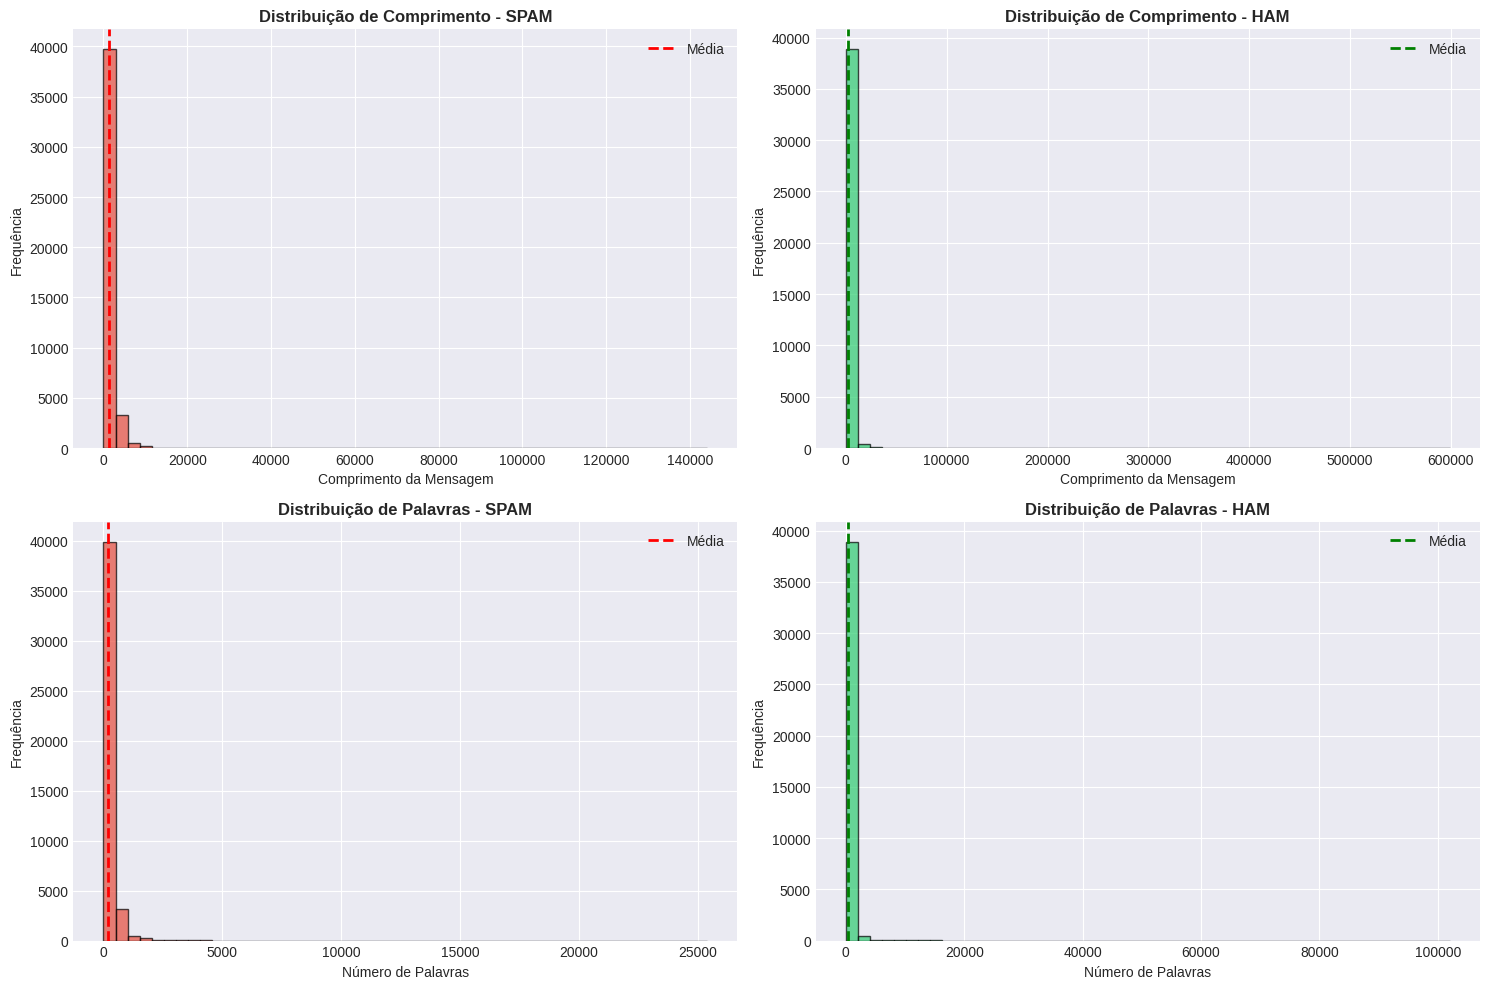

In [8]:
# Visualizações de tamanho das mensagens
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Distribuição de comprimento de mensagem
df[df['label'] == 'spam']['message_length'].hist(
    bins=50, ax=axes[0, 0], color='#e74c3c', alpha=0.7, edgecolor='black'
)
axes[0, 0].set_title('Distribuição de Comprimento - SPAM', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Comprimento da Mensagem', fontsize=10)
axes[0, 0].set_ylabel('Frequência', fontsize=10)
axes[0, 0].axvline(df[df['label'] == 'spam']['message_length'].mean(), 
                   color='red', linestyle='--', linewidth=2, label='Média')
axes[0, 0].legend()

df[df['label'] == 'ham']['message_length'].hist(
    bins=50, ax=axes[0, 1], color='#2ecc71', alpha=0.7, edgecolor='black'
)
axes[0, 1].set_title('Distribuição de Comprimento - HAM', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Comprimento da Mensagem', fontsize=10)
axes[0, 1].set_ylabel('Frequência', fontsize=10)
axes[0, 1].axvline(df[df['label'] == 'ham']['message_length'].mean(), 
                   color='green', linestyle='--', linewidth=2, label='Média')
axes[0, 1].legend()

# Plot 3: Distribuição de contagem de palavras
df[df['label'] == 'spam']['word_count'].hist(
    bins=50, ax=axes[1, 0], color='#e74c3c', alpha=0.7, edgecolor='black'
)
axes[1, 0].set_title('Distribuição de Palavras - SPAM', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Número de Palavras', fontsize=10)
axes[1, 0].set_ylabel('Frequência', fontsize=10)
axes[1, 0].axvline(df[df['label'] == 'spam']['word_count'].mean(), 
                   color='red', linestyle='--', linewidth=2, label='Média')
axes[1, 0].legend()

df[df['label'] == 'ham']['word_count'].hist(
    bins=50, ax=axes[1, 1], color='#2ecc71', alpha=0.7, edgecolor='black'
)
axes[1, 1].set_title('Distribuição de Palavras - HAM', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Número de Palavras', fontsize=10)
axes[1, 1].set_ylabel('Frequência', fontsize=10)
axes[1, 1].axvline(df[df['label'] == 'ham']['word_count'].mean(), 
                   color='green', linestyle='--', linewidth=2, label='Média')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

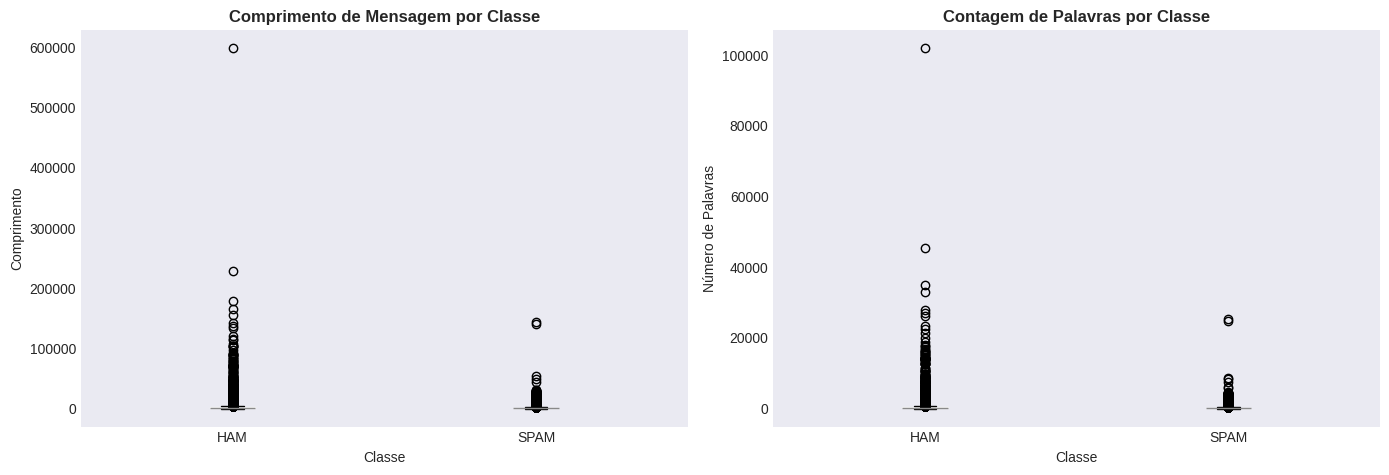

In [9]:
# Boxplot comparando spam vs ham
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot de comprimento
df.boxplot(column='message_length', by='label', ax=axes[0], 
           patch_artist=True, grid=False)
axes[0].set_title('Comprimento de Mensagem por Classe', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Classe', fontsize=10)
axes[0].set_ylabel('Comprimento', fontsize=10)
plt.sca(axes[0])
plt.xticks([1, 2], ['HAM', 'SPAM'])

# Boxplot de contagem de palavras
df.boxplot(column='word_count', by='label', ax=axes[1], 
           patch_artist=True, grid=False)
axes[1].set_title('Contagem de Palavras por Classe', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Classe', fontsize=10)
axes[1].set_ylabel('Número de Palavras', fontsize=10)
plt.sca(axes[1])
plt.xticks([1, 2], ['HAM', 'SPAM'])

plt.suptitle('')
plt.tight_layout()
plt.show()

## Análise de Palavras Mais Comuns

Vamos identificar as palavras mais frequentes em mensagens spam e ham.

In [10]:
# Função para processar e limpar texto
def clean_text(text):
    """
    Remove caracteres especiais e converte para lowercase.
    """
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

def get_top_words(texts, n=20, remove_stopwords=True):
    """
    Retorna as n palavras mais comuns.
    
    Args:
        texts: Lista de textos
        n: Número de palavras a retornar
        remove_stopwords: Se True, remove stopwords
    
    Returns:
        Lista de tuplas (palavra, frequência)
    """
    # Juntar todos os textos
    all_text = ' '.join(texts)
    
    # Limpar e tokenizar
    words = clean_text(all_text).split()
    
    # Remover stopwords se necessário
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        words = [w for w in words if w not in stop_words and len(w) > 2]
    
    # Contar palavras
    word_freq = Counter(words)
    
    return word_freq.most_common(n)

In [11]:
# Palavras mais comuns em SPAM
spam_messages = df[df['label'] == 'spam']['message'].tolist()
top_spam_words = get_top_words(spam_messages, n=20)

print("\nPalavra              | Frequência")
print("-" * 35)
for word, freq in top_spam_words:
    print(f"{word:20} | {freq:,}")


Palavra              | Frequência
-----------------------------------
escapenumber         | 337,227
escapelong           | 188,117
com                  | 29,009
http                 | 27,774
per                  | 26,143
pills                | 23,128
escapenumbermg       | 20,541
price                | 18,724
company              | 15,871
one                  | 15,858
save                 | 15,007
may                  | 14,670
item                 | 14,473
time                 | 12,357
please               | 12,333
get                  | 11,997
new                  | 11,402
money                | 11,379
information          | 11,158
see                  | 10,821


In [12]:
# Palavras mais comuns em HAM
ham_messages = df[df['label'] == 'ham']['message'].tolist()
top_ham_words = get_top_words(ham_messages, n=20)

print("\nPalavra              | Frequência")
print("-" * 35)
for word, freq in top_ham_words:
    print(f"{word:20} | {freq:,}")


Palavra              | Frequência
-----------------------------------
escapenumber         | 802,246
http                 | 54,399
enron                | 52,856
org                  | 42,557
com                  | 40,681
escapelong           | 39,078
ect                  | 34,743
help                 | 32,663
samba                | 30,736
list                 | 28,271
www                  | 28,191
please               | 26,798
new                  | 25,735
source               | 25,572
would                | 25,382
data                 | 22,043
may                  | 21,611
stat                 | 21,226
ethz                 | 20,493
html                 | 19,620


## Por que Analisar Palavras Mais Comuns?

Identificar palavras frequentes é essencial porque:

### 1. Padrões de Vocabulário

- **Spam**: Usa palavras como "free", "win", "click", "offer", "prize"
- **Ham**: Usa palavras do dia a dia, nomes, contextos específicos

### 2. Feature Engineering

- Palavras mais discriminativas viram features importantes
- TF-IDF vai dar peso maior para palavras únicas de cada classe
- Ajuda a criar filtros e regras

### 3. Stopwords

Palavras muito comuns ("the", "a", "is") aparecem em ambas classes e não ajudam na classificação. Por isso removemos stopwords para focar nas palavras significativas.

### 4. Insights de Negócio

Entender quais palavras caracterizam spam ajuda a:
- Explicar o modelo para stakeholders
- Criar regras de negócio
- Validar se o modelo está aprendendo corretamente

## WordCloud - Nuvem de Palavras

WordCloud é uma visualização que mostra palavras mais frequentes em tamanhos proporcionais à sua frequência.

**Por que usar?**
- Visualização rápida e intuitiva das palavras dominantes
- Identifica padrões de vocabulário
- Facilita comparação visual entre spam e ham
- Útil para apresentações e relatórios

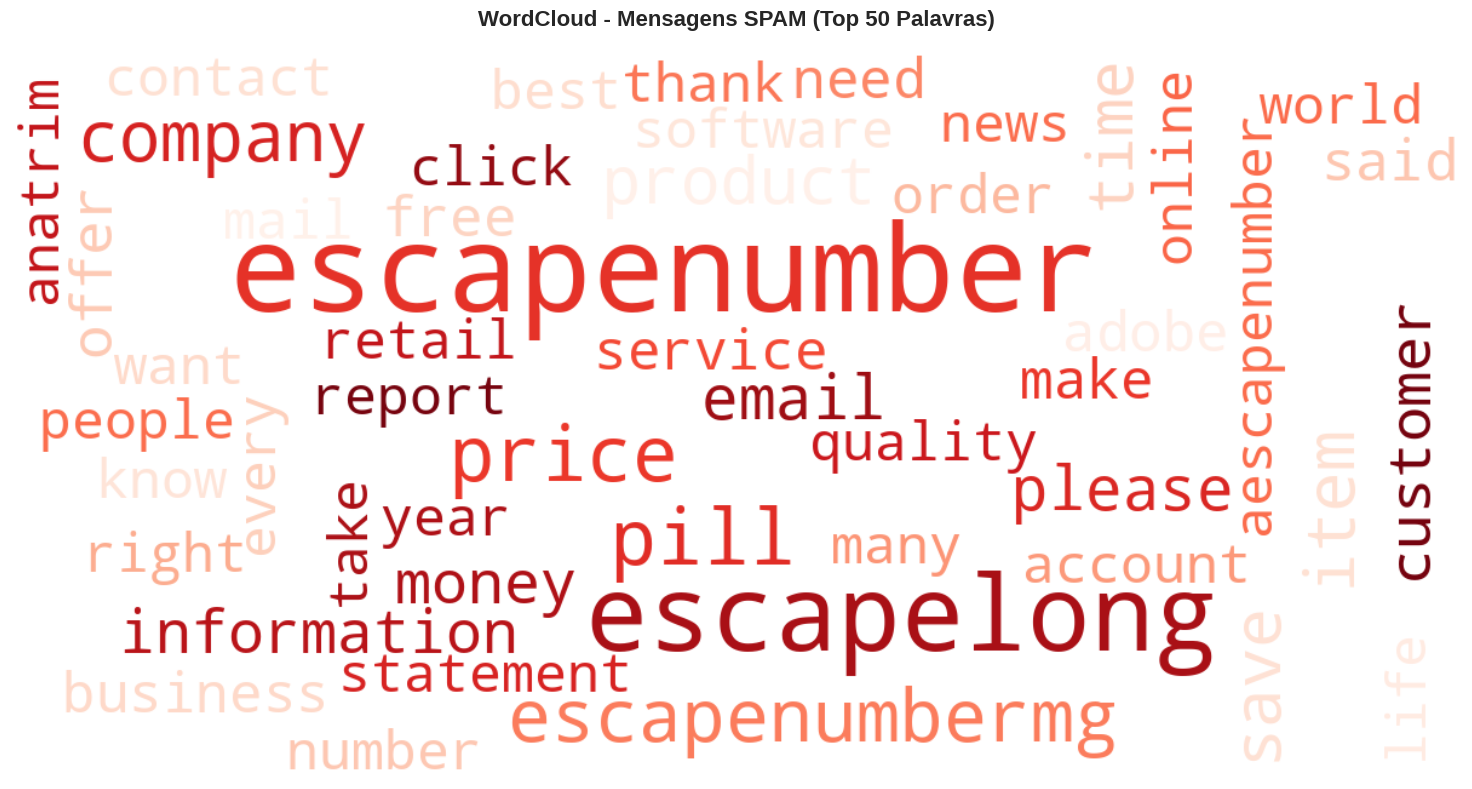

In [13]:
# WordCloud para mensagens SPAM
spam_text = ' '.join(df[df['label'] == 'spam']['message'].astype(str))
spam_text_clean = clean_text(spam_text)

# Remover stopwords
stop_words = set(stopwords.words('english'))
spam_words = [w for w in spam_text_clean.split() if w not in stop_words and len(w) > 3]

# Criar texto final sem duplicatas consecutivas
spam_text_final = ' '.join(spam_words)

# Criar WordCloud com configurações otimizadas
wordcloud_spam = WordCloud(
    width=1200,
    height=600,
    background_color='white',
    colormap='Reds',
    max_words=50,  # Reduzido para mostrar apenas as mais importantes
    relative_scaling=0.3,  # Menor variação de tamanho
    min_font_size=10,
    max_font_size=100,
    collocations=False  # IMPORTANTE: Evita bigramas repetidos
).generate(spam_text_final)

# Plotar
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Mensagens SPAM (Top 50 Palavras)', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


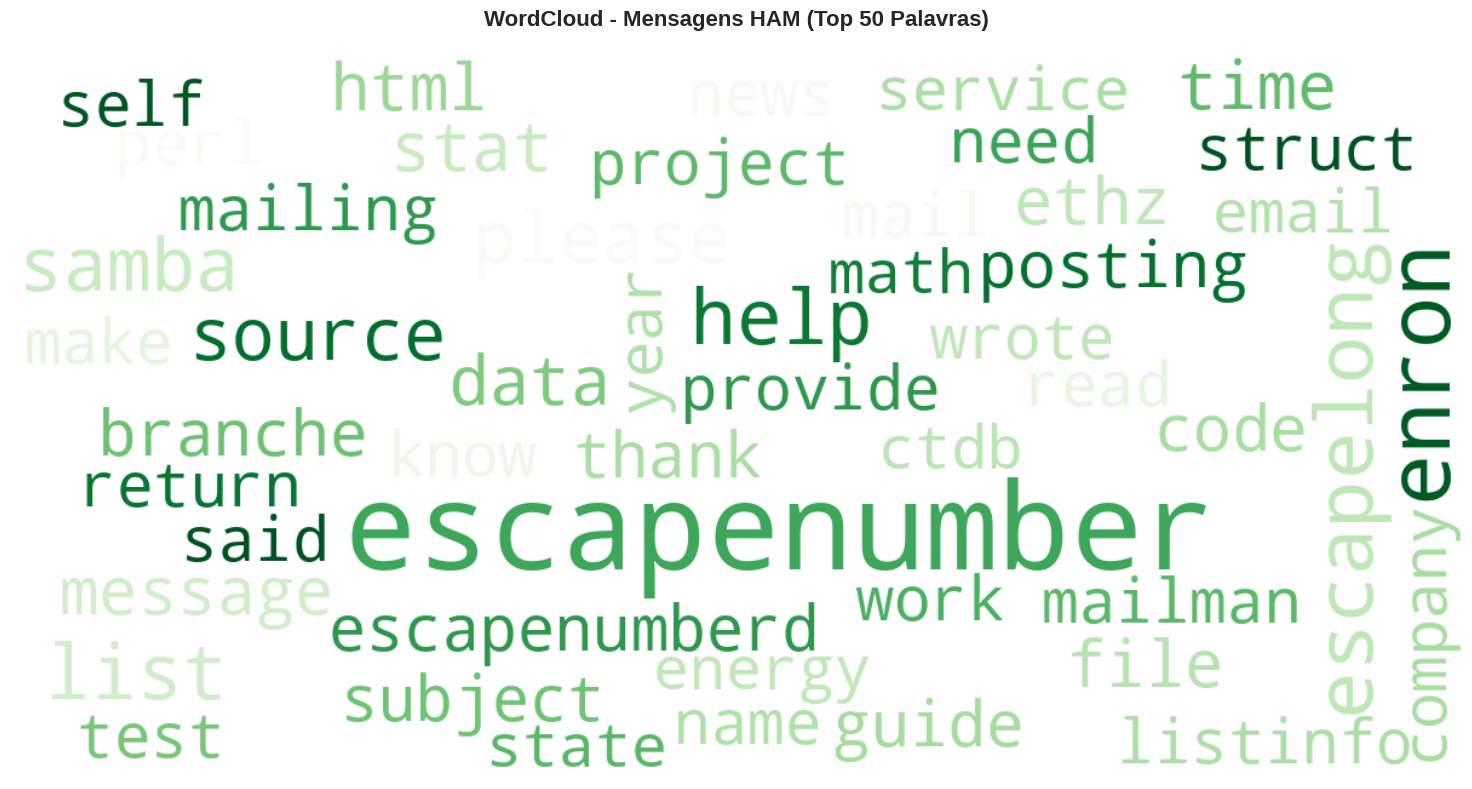

In [14]:
# WordCloud para mensagens HAM
ham_text = ' '.join(df[df['label'] == 'ham']['message'].astype(str))
ham_text_clean = clean_text(ham_text)

# Remover stopwords e palavras muito curtas
ham_words = [w for w in ham_text_clean.split() if w not in stop_words and len(w) > 3]

# Criar texto final
ham_text_final = ' '.join(ham_words)

# Criar WordCloud com configurações otimizadas
wordcloud_ham = WordCloud(
    width=1200,
    height=600,
    background_color='white',
    colormap='Greens',
    max_words=50,  # Reduzido para mostrar apenas as mais importantes
    relative_scaling=0.3,  # Menor variação de tamanho
    min_font_size=10,
    max_font_size=100,
    collocations=False  # IMPORTANTE: Evita bigramas repetidos
).generate(ham_text_final)

# Plotar
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud_ham, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Mensagens HAM (Top 50 Palavras)', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## Análise de Caracteres Especiais

Mensagens de spam frequentemente contêm:
- Muitos números (preços, telefones)
- Símbolos especiais (!, $, %)
- URLs
- Maiúsculas excessivas

Vamos quantificar isso para ver se são features úteis.

In [15]:
# Criar features de caracteres especiais
df['num_count'] = df['message'].apply(lambda x: len(re.findall(r'\d', str(x))))
df['special_char_count'] = df['message'].apply(lambda x: len(re.findall(r'[^a-zA-Z0-9\s]', str(x))))
df['uppercase_count'] = df['message'].apply(lambda x: len(re.findall(r'[A-Z]', str(x))))
df['url_count'] = df['message'].apply(lambda x: len(re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', str(x))))

# Comparar médias
print("="*70)
print("ANÁLISE DE CARACTERES ESPECIAIS")
print("="*70)

features = ['num_count', 'special_char_count', 'uppercase_count', 'url_count']

comparison = pd.DataFrame({
    'SPAM': df[df['label'] == 'spam'][features].mean(),
    'HAM': df[df['label'] == 'ham'][features].mean(),
    'Diferença': df[df['label'] == 'spam'][features].mean() - df[df['label'] == 'ham'][features].mean()
})

print("\nMédia por Classe:")
print(comparison.round(2))

print("\nInsight:")
for feature in features:
    spam_avg = df[df['label'] == 'spam'][feature].mean()
    ham_avg = df[df['label'] == 'ham'][feature].mean()
    
    if spam_avg > ham_avg * 1.5:
        print(f"- {feature}: SPAM tem {(spam_avg/ham_avg):.2f}x mais que HAM")
    elif ham_avg > spam_avg * 1.5:
        print(f"- {feature}: HAM tem {(ham_avg/spam_avg):.2f}x mais que SPAM")
    else:
        print(f"- {feature}: Valores similares entre classes")

ANÁLISE DE CARACTERES ESPECIAIS

Média por Classe:
                     SPAM    HAM  Diferença
num_count            8.22  17.38      -9.16
special_char_count  33.18  38.80      -5.61
uppercase_count      0.00   0.00       0.00
url_count            0.00   0.00       0.00

Insight:
- num_count: HAM tem 2.11x mais que SPAM
- special_char_count: Valores similares entre classes
- uppercase_count: Valores similares entre classes
- url_count: Valores similares entre classes


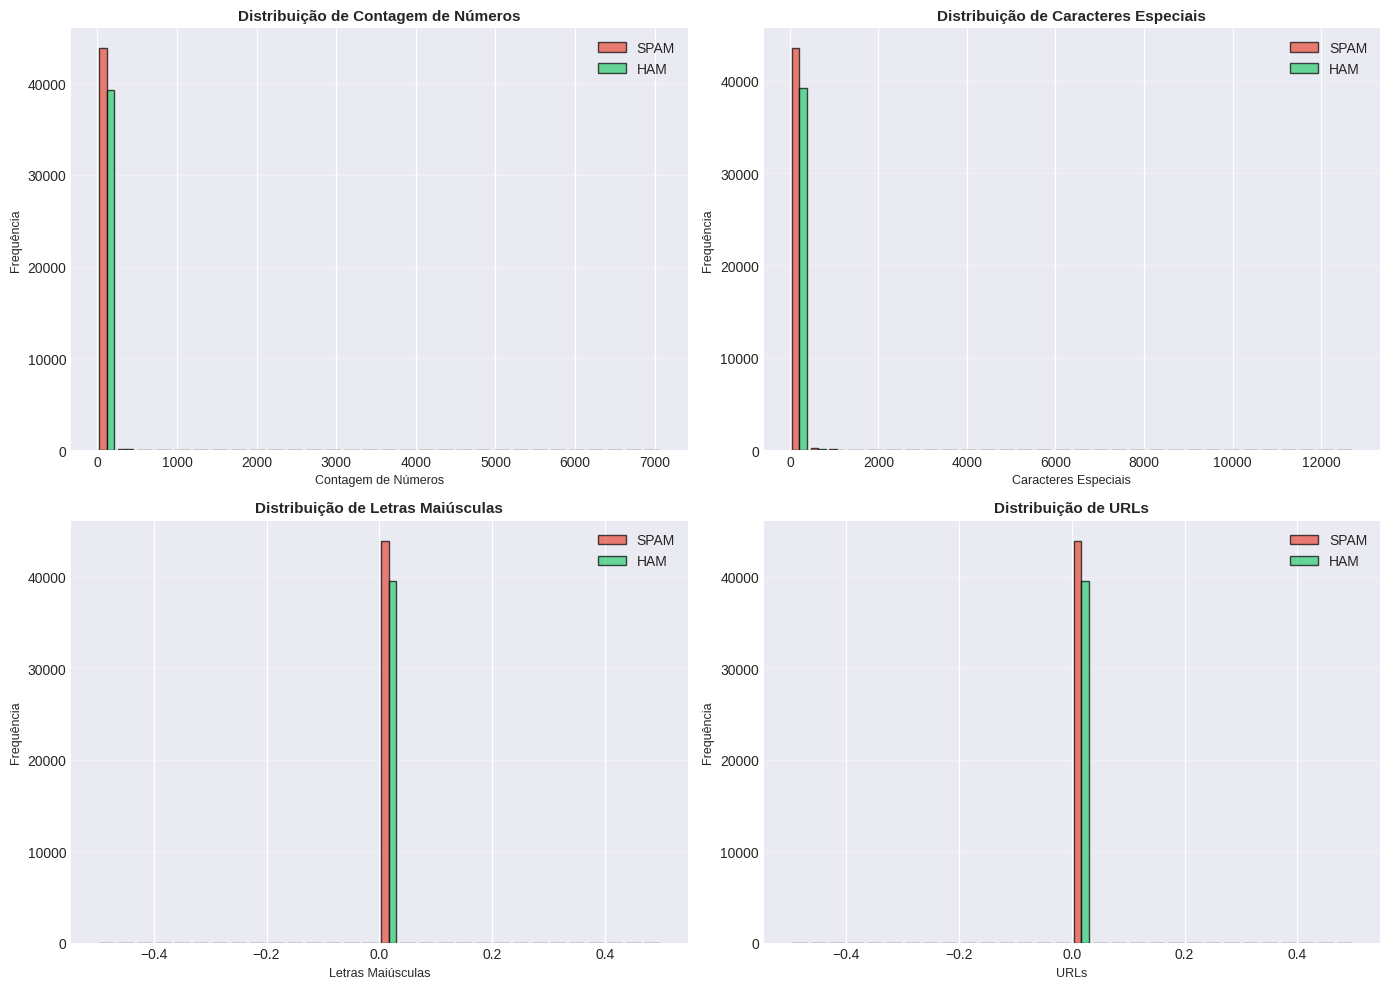

In [16]:
# Visualizar distribuição de caracteres especiais
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

features_to_plot = [
    ('num_count', 'Contagem de Números'),
    ('special_char_count', 'Caracteres Especiais'),
    ('uppercase_count', 'Letras Maiúsculas'),
    ('url_count', 'URLs')
]

for idx, (feature, title) in enumerate(features_to_plot):
    ax = axes[idx // 2, idx % 2]
    
    # Dados
    spam_data = df[df['label'] == 'spam'][feature]
    ham_data = df[df['label'] == 'ham'][feature]
    
    # Plot
    ax.hist([spam_data, ham_data], bins=30, label=['SPAM', 'HAM'], 
            color=['#e74c3c', '#2ecc71'], alpha=0.7, edgecolor='black')
    ax.set_title(f'Distribuição de {title}', fontsize=11, fontweight='bold')
    ax.set_xlabel(title, fontsize=9)
    ax.set_ylabel('Frequência', fontsize=9)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Insights da Análise Exploratória

Com base na análise realizada, podemos concluir:

### 1. Qualidade dos Dados
- Dataset limpo sem valores nulos
- 83,448 emails é um tamanho robusto para treinamento
- Bem balanceado (52% spam, 48% ham)

### 2. Características do Texto
- Tamanho das mensagens varia entre classes
- Vocabulário distinto entre spam e ham
- Spam contém mais caracteres especiais e números

### 3. Features Potenciais
Podemos usar como features:
- TF-IDF do texto (principal)
- Comprimento da mensagem
- Contagem de números
- Contagem de caracteres especiais
- Contagem de URLs
- Contagem de maiúsculas

### 4. Próximos Passos
1. Preprocessar o texto (lowercase, remoção de pontuação)
2. Aplicar TF-IDF ou CountVectorizer
3. Treinar múltiplos modelos (Naive Bayes, SVM, Random Forest)
4. Comparar métricas (Accuracy, Precision, Recall, F1)
5. Selecionar o melhor modelo

## Preprocessamento de Texto

Agora vamos preparar os dados para treinamento do modelo.

**Etapas do Preprocessamento:**
1. Limpeza de texto (lowercase, remover pontuação)
2. Tokenização (dividir texto em palavras)
3. Remoção de stopwords
4. Vetorização (converter texto em números)

**Por que fazer isso?**
Modelos de ML não entendem texto, apenas números. Precisamos converter as mensagens em vetores numéricos usando técnicas como TF-IDF ou CountVectorizer.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

def preprocess_text(text):
    """
    Preprocessa texto para modelo ML.
    
    Args:
        text: Texto bruto
    
    Returns:
        Texto limpo e preprocessado
    """
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+', '', text) # Remover URLs
    text = re.sub(r'\S+@\S+', '', text) # Remover emails
    text = re.sub(r'[^a-zA-Z\s]', ' ', text) # Remover pontuação e caracteres especiais
    text = re.sub(r'\s+', ' ', text) # Remover espaços múltiplos
    text = text.strip() # Remover espaços no início e fim
    return text

In [18]:
# Aplicar preprocessamento em todo dataset
df['message_clean'] = df['message'].apply(preprocess_text)

# Verificar resultados
print("\nExemplos de preprocessamento:")
print("\n--- SPAM ---")
for i in range(2):
    print(f"\nOriginal: {df[df['label'] == 'spam'].iloc[i]['message'][:100]}...")
    print(f"Limpo: {df[df['label'] == 'spam'].iloc[i]['message_clean'][:100]}...")

print("\n--- HAM ---")
for i in range(2):
    print(f"\nOriginal: {df[df['label'] == 'ham'].iloc[i]['message'][:100]}...")
    print(f"Limpo: {df[df['label'] == 'ham'].iloc[i]['message_clean'][:100]}...")


Exemplos de preprocessamento:

--- SPAM ---

Original: ounce feather bowl hummingbird opec moment alabaster valkyrie dyad bread flack desperate iambic hadr...
Limpo: ounce feather bowl hummingbird opec moment alabaster valkyrie dyad bread flack desperate iambic hadr...

Original: wulvob get your medircations online qnb ikud viagra escapenumber escapenumber levitra escapenumber e...
Limpo: wulvob get your medircations online qnb ikud viagra escapenumber escapenumber levitra escapenumber e...

--- HAM ---

Original:  computer connection from cnn com wednesday escapenumber may escapenumber escapenumber escapenumber ...
Limpo: computer connection from cnn com wednesday escapenumber may escapenumber escapenumber escapenumber e...

Original: thanks for all your answers guys i know i should have checked the rsync manual but i would rather ge...
Limpo: thanks for all your answers guys i know i should have checked the rsync manual but i would rather ge...


## Divisão dos Dados (Train/Test Split)

**Por que dividir?**
- **Train (80%)**: Usado para treinar o modelo
- **Test (20%)**: Usado para avaliar a performance real do modelo

**Importante:** O modelo NUNCA vê os dados de teste durante o treinamento. Isso garante que estamos avaliando a capacidade de generalização do modelo.

**Stratify:** Mantém a mesma proporção de spam/ham em ambos os conjuntos.

In [19]:
X = df['message_clean']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)
print(f"\nTotal de emails: {len(df):,}")
print(f"\nTreino: {len(X_train):,} ({len(X_train)/len(df)*100:.1f}%)")
print(f"Teste: {len(X_test):,} ({len(X_test)/len(df)*100:.1f}%)")
print("\nDistribuição em Treino:")
print(y_train.value_counts())
print(f"\nPercentual:")
print((y_train.value_counts(normalize=True) * 100).round(2))
print("\nDistribuição em Teste:")
print(y_test.value_counts())
print(f"\nPercentual:")
print((y_test.value_counts(normalize=True) * 100).round(2))


Total de emails: 83,448

Treino: 66,758 (80.0%)
Teste: 16,690 (20.0%)

Distribuição em Treino:
label
spam    35128
ham     31630
Name: count, dtype: int64

Percentual:
label
spam    52.62
ham     47.38
Name: proportion, dtype: float64

Distribuição em Teste:
label
spam    8782
ham     7908
Name: count, dtype: int64

Percentual:
label
spam    52.62
ham     47.38
Name: proportion, dtype: float64


## Vetorização de Texto

**O que é?**
Converter texto em números que o modelo pode processar.

**Técnicas:**

### 1. CountVectorizer
- Conta frequência de cada palavra
- Simples e rápido
- Ignora importância relativa

### 2. TF-IDF (Term Frequency - Inverse Document Frequency)
- Pondera frequência pela raridade
- Palavras raras e importantes têm peso maior
- Palavras comuns têm peso menor
- Melhor para classificação

**Vamos usar TF-IDF** por ser mais efetivo em classificação de spam.

In [20]:
# Criar vetorizador TF-IDF
tfidf = TfidfVectorizer(
    max_features=5000,  # Top 5000 palavras mais importantes
    min_df=2,           # Palavra deve aparecer em pelo menos 2 documentos
    max_df=0.95,        # Ignorar palavras em mais de 95% dos documentos
    ngram_range=(1, 2), # Unigramas e bigramas
    stop_words='english'
)

# Fit apenas no treino (importante!)
print("Aplicando TF-IDF...")
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("\nVetorização concluída!")
print(f"\nShape do treino: {X_train_tfidf.shape}")
print(f"Shape do teste: {X_test_tfidf.shape}")
print(f"\nVocabulário: {len(tfidf.vocabulary_):,} palavras únicas")
print(f"Features: {X_train_tfidf.shape[1]:,}")

# Top features (palavras com maior TF-IDF médio)
feature_names = tfidf.get_feature_names_out()
print(f"\nExemplos de features criadas:")
print(feature_names[:20])

Aplicando TF-IDF...

Vetorização concluída!

Shape do treino: (66758, 5000)
Shape do teste: (16690, 5000)

Vocabulário: 5,000 palavras únicas
Features: 5,000

Exemplos de features criadas:
['aa' 'ab' 'abbott' 'abc' 'ability' 'able' 'absolutely' 'abuse' 'ac'
 'ac uk' 'academy' 'accept' 'acceptable' 'acceptance' 'accepted' 'access'
 'according' 'account' 'account manager' 'accounting']


In [21]:
import joblib
from pathlib import Path

# Criar diretório para artefatos
artifacts_dir = Path('artifacts')
artifacts_dir.mkdir(exist_ok=True)

# Salvar vetorizador
tfidf_path = artifacts_dir / 'tfidf_vectorizer.joblib'
joblib.dump(tfidf, tfidf_path)

# Salvar splits
data_splits = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'X_train_tfidf': X_train_tfidf,
    'X_test_tfidf': X_test_tfidf
}

splits_path = artifacts_dir / 'data_splits.joblib'
joblib.dump(data_splits, splits_path)

print("Artefatos salvos:")
print(f"- Vetorizador TF-IDF: {tfidf_path}")
print(f"- Data splits: {splits_path}")
print("\nDados prontos para o próximo notebook (02_model_training.ipynb)!")

Artefatos salvos:
- Vetorizador TF-IDF: artifacts/tfidf_vectorizer.joblib
- Data splits: artifacts/data_splits.joblib

Dados prontos para o próximo notebook (02_model_training.ipynb)!


## Conclusão da Análise Exploratória

### O que foi feito:

1. Carregamento e validação de 83,448 emails
2. Análise de distribuição (52% spam, 48% ham)
3. Análise de tamanho e características do texto
4. Identificação de palavras mais comuns
5. Criação de features numéricas
6. Preprocessamento de texto
7. Divisão treino/teste (80/20)
8. Vetorização TF-IDF

### Artefatos Gerados:

- `emails_with_features.csv`: Dataset com features adicionadas
- `artifacts/tfidf_vectorizer.joblib`: Vetorizador treinado
- `artifacts/data_splits.joblib`: Dados divididos e vetorizados

### Próximo Passo:

**Notebook 02: Model Training**
- Treinar múltiplos modelos (Naive Bayes, SVM, Random Forest, XGBoost)
- Comparar métricas (Accuracy, Precision, Recall, F1)
- Selecionar melhor modelo
- Otimizar hiperparâmetros
- Exportar modelo final